<a href="https://colab.research.google.com/github/kahram-y/first-repository/blob/master/etc/time_series_as_features_kor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 셋팅 #

필요한 설정을 위해 이 셀을 실행하세요!


In [1]:
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
store_sales_time_series_forecasting_path = kagglehub.competition_download('store-sales-time-series-forecasting')
ryanholbrook_ts_course_data_path = kagglehub.dataset_download('ryanholbrook/ts-course-data')

print('Data source import complete.')


100%|██████████| 21.4M/21.4M [00:00<00:00, 82.5MB/s]

Extracting files...


Using Colab cache for faster access to the 'ts-course-data' dataset.
Data source import complete.


In [4]:
import os
from pathlib import Path

# Define the target directory where learntools expects to find the data
input_base_path = Path('/input')
input_base_path.mkdir(parents=True, exist_ok=True)

# Create a symbolic link for the store-sales-time-series-forecasting competition data
symlink_target_comp = input_base_path / 'store-sales-time-series-forecasting'
symlink_source_comp = store_sales_time_series_forecasting_path

if symlink_target_comp.exists() or symlink_target_comp.is_symlink():
    if symlink_target_comp.is_symlink():
        os.unlink(symlink_target_comp)
    else:
        # If it's a directory, remove it to replace with symlink
        import shutil
        shutil.rmtree(symlink_target_comp)

os.symlink(symlink_source_comp, symlink_target_comp)
print(f"Created symlink: {symlink_target_comp} -> {symlink_source_comp}")

# Create a symbolic link for the ryanholbrook/ts-course-data dataset
symlink_target_data = input_base_path / 'ts-course-data'
symlink_source_data = ryanholbrook_ts_course_data_path

if symlink_target_data.exists() or symlink_target_data.is_symlink():
    if symlink_target_data.is_symlink():
        os.unlink(symlink_target_data)
    else:
        import shutil
        shutil.rmtree(symlink_target_data)

os.symlink(symlink_source_data, symlink_target_data)
print(f"Created symlink: {symlink_target_data} -> {symlink_source_data}")


Created symlink: /input/store-sales-time-series-forecasting -> /root/.cache/kagglehub/competitions/store-sales-time-series-forecasting
Created symlink: /input/ts-course-data -> /kaggle/input/ts-course-data


In [5]:
!git clone https://github.com/Kaggle/learntools.git
!mv learntools learntools_dir
!mv learntools_dir/learntools learntools

Cloning into 'learntools'...
remote: Enumerating objects: 18766, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 18766 (delta 243), reused 165 (delta 155), pack-reused 18452 (from 3)
Receiving objects: 100% (18766/18766), 105.27 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (13801/13801), done.


# Serial Dependence이란? #

이전 강의에서는 시간 인덱스에서 직접 만들 수 있는 피처로 가장 쉽게 설명되는 시계열 속성들을 살펴봤습니다. 이런 속성들은 *시간 의존성(time dependence)* 을 갖습니다. 그러나 일부 시계열 속성은 *직렬 의존성(serial dependence)* 으로만 모델링할 수 있습니다. 즉, 타깃 시리즈의 과거 값을 피처로 사용해야만 구조가 드러납니다. 이 구조는 시간 플롯에서는 잘 보이지 않지만, 과거 값과 현재 값을 함께 그린 플롯에서는 뚜렷하게 나타납니다.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X0sSnwp.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>왼쪽 시리즈는 시간 의존성을, 오른쪽 시리즈는 직렬 의존성을 보여 줍니다. 오른쪽 점의 좌표는 <code>(t-1 시점 값, t 시점 값)</code>입니다.
</center></figcaption>
</figure>

추세와 계절성을 다룰 때는 그림 왼쪽처럼 시간 축에 곡선을 맞추도록 모델을 학습해 왔습니다. 이번 강의의 목표는 그림 오른쪽처럼 과거 값과 현재 값을 함께 그린 플롯에 곡선을 맞추도록 모델을 학습시키는 것입니다.

### 주기(Cycles)

직렬 의존성이 나타나는 가장 흔한 방식이 **주기(cycle)** 입니다. 주기는 시계열 값이 직전 값에 어떻게 의존하느냐에 따라 성장과 감소가 반복되는 패턴입니다. 특정 시간 단계 자체보다는 최근에 어떤 일이 일어났는지가 더 중요할 때 나타납니다. 자기 자신에게 영향을 주거나 효과가 시간이 지나며 유지되는 시스템에서 이런 주기가 잘 보입니다. 예를 들어 경제, 전염병, 동물 개체 수, 화산 활동 등 자연 현상에서 주기가 자주 나타납니다.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/CC3TkAf.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>주기적 행동을 보이는 네 가지 시계열.
</center></figcaption>
</figure>

계절성과 주기를 구분하는 핵심은 주기는 계절처럼 반드시 시간 의존적이지는 않다는 점입니다. 주기에서 중요한 것은 특정 날짜가 아니라 최근에 어떤 일이 있었는지입니다. 시간에서 상대적으로 독립적이기 때문에 주기는 계절성보다 훨씬 불규칙할 수 있습니다.

# 래그 시리즈와 래그 플롯 #

시계열에서 주기와 같은 직렬 의존성을 살펴보려면 시리즈의 "래그된(lagged)" 복사본을 만들어야 합니다. 시계열을 **래그(lag)** 한다는 것은 값을 한두 단계 앞으로 이동시키거나, 동일하게 인덱스의 시간을 한두 단계 뒤로 이동시키는 것을 의미합니다. 두 방식 모두 래그된 시리즈의 관측값이 더 나중에 일어난 것처럼 보이게 합니다.

아래 그림은 미국의 월별 실업률 시리즈(`y`)와 첫 번째, 두 번째 래그 시리즈(`y_lag_1`, `y_lag_2`)를 보여 줍니다. 래그 시리즈의 값이 시간이 지남에 따라 얼마나 이동했는지 확인할 수 있습니다.


In [6]:
import pandas as pd

# 미 연준(Federal Reserve) 데이터셋: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "../input/ts-course-data/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),
})

df.head()


/tmp/ipython-input-2310755034.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  reserve = pd.read_csv(


,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


시계열을 래그하면 과거 값을 우리가 예측하려는 값과 같은 행(같은 시점)에 놓을 수 있습니다. 따라서 래그 시리즈는 직렬 의존성을 모델링하는 피처로 유용합니다. 예를 들어 미국 실업률을 예측할 때 `y_lag_1`, `y_lag_2`를 피처로 사용해 타깃 `y`를 예측할 수 있습니다. 그렇게 하면 향후 실업률을 직전 두 달의 실업률 함수로 모델링하는 셈입니다.

### 래그 플롯

시계열의 **래그 플롯**은 값과 래그 값을 서로 대응시켜 그린 그래프입니다. 직렬 의존성은 래그 플롯에서 자주 드러납니다. 아래의 *US Unemployment* 래그 플롯을 보면 현재 실업률과 과거 실업률 사이에 강하고 거의 선형적인 관계가 있음을 알 수 있습니다.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Hvrboya.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>US Unemployment의 래그 플롯과 자기상관 계수.
</center></figcaption>
</figure>

직렬 의존성을 측정할 때 가장 많이 사용하는 지표는 시계열이 자신의 래그와 갖는 상관관계인 **자기상관(autocorrelation)** 입니다. *US Unemployment*는 1 스텝 래그에서 0.99, 2 스텝 래그에서 0.98 등 매우 높은 자기상관을 보입니다.

### 래그 선택하기

피처로 사용할 래그를 고를 때는 자기상관이 크다고 해서 모든 래그를 포함하는 것은 도움이 되지 않을 수 있습니다. 예를 들어 *US Unemployment*에서 래그 2의 자기상관은 래그 1에서 전달된 정보만으로도 설명될 수 있습니다. 래그 2가 새로운 정보를 제공하지 않는다면 이미 래그 1을 사용하고 있을 때 추가할 이유가 없습니다.

**편자기상관(partial autocorrelation)** 은 이전 래그들의 영향을 제거하고 남은, 해당 래그가 새롭게 제공하는 상관을 알려 줍니다. 편자기상관을 플롯하면 어떤 래그 피처를 쓸지 결정하는 데 도움이 됩니다. 아래 그림에서는 래그 1부터 6까지가 파란색으로 표시한 “상관 없음” 구간 밖에 있으므로 *US Unemployment*를 모델링할 때 래그 1~6을 피처로 사용할 수 있겠습니다(래그 11은 우연히 나온 값일 가능성이 큽니다).

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/6nTe94E.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>US Unemployment의 편자기상관(랩 12까지)과 95% 신뢰구간.
</center></figcaption>
</figure>

이런 플롯을 **상관도(correlogram)** 라고 하며, 래그 피처를 고르는 데 있어 상관도는 푸리에 피처를 위한 주파수 스펙트럼과 유사한 역할을 합니다.

마지막으로 자기상관과 편자기상관은 모두 *선형* 의존성만 측정한다는 사실을 기억해야 합니다. 현실 세계의 시계열에는 비선형 의존성이 많이 존재하므로, 래그 피처를 고를 때는 래그 플롯을 직접 살펴보거나 [상호 정보량](https://www.kaggle.com/ryanholbrook/mutual-information)과 같은 더 일반적인 의존성 측도를 사용하는 것이 좋습니다. *Sunspots* 시리즈에는 비선형 의존성을 가진 래그가 있는데, 자기상관만 보면 놓칠 수도 있습니다.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Q38UVOu.png" width=350, alt="">
    <figcaption style="textalign: center; font-style: italic"><center><em>Sunspots</em> 시리즈의 래그 플롯.
</center></figcaption>
</figure>

이런 비선형 관계는 적절한 변환으로 선형화하거나, 비선형 관계를 학습할 수 있는 알고리즘으로 직접 학습할 수 있습니다.

# 예제 - Flu Trends #

*Flu Trends* 데이터셋에는 2009년부터 2016년까지의 독감 관련 병원 방문 기록이 들어 있습니다. 목표는 향후 몇 주 동안의 독감 환자 수를 예측하는 것입니다.

여기서는 두 가지 접근법을 시도해 보겠습니다. 첫 번째는 타깃 시리즈의 래그 피처를 사용해 병원 방문 수를 예측하는 방법입니다. 두 번째는 *다른* 시계열(구글 트렌드에서 수집한 독감 관련 검색어)을 래그하여 피처로 사용하는 방법입니다.


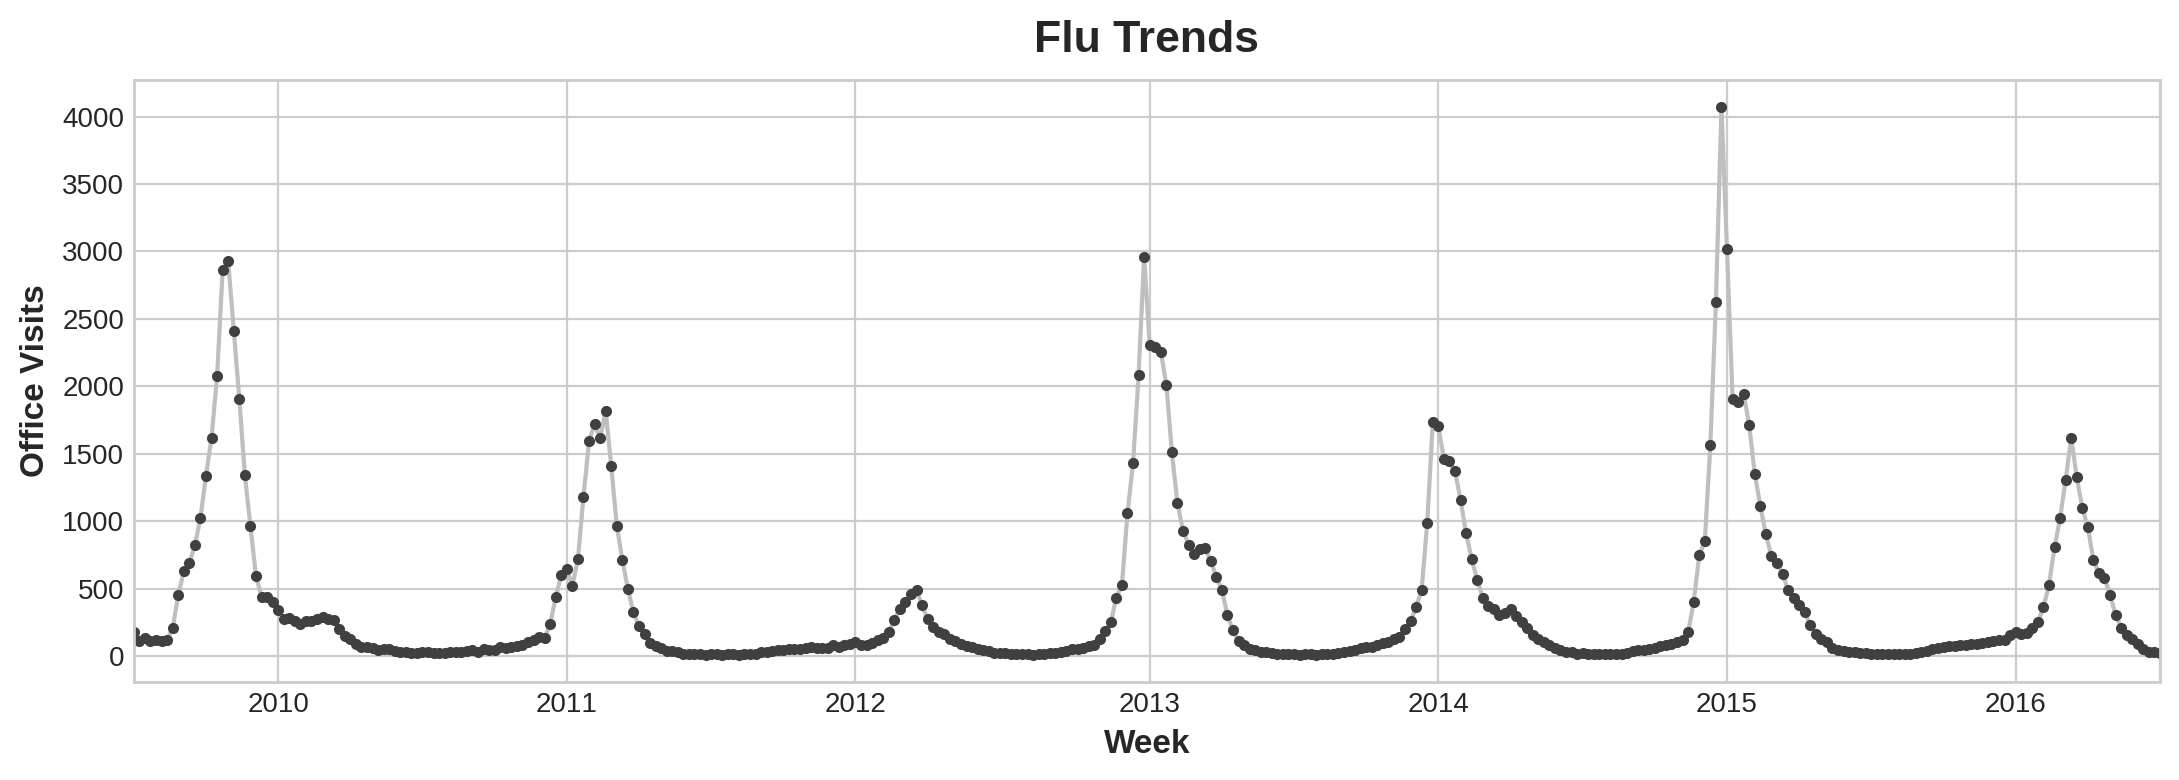

In [7]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Matplotlib 기본 설정
plt.style.use("seaborn-v0_8-whitegrid") # 'seaborn-whitegrid' 대신 'ggplot' 사용
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


data_dir = Path("../input/ts-course-data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

*Flu Trends* 데이터에서는 규칙적인 계절성보다는 불규칙한 주기가 나타납니다. 보통 연초에 피크가 있지만 때로는 더 이르거나 늦게出现하고, 크기도 제각각입니다. 이런 주기를 래그 피처로 모델링하면 계절 피처처럼 특정 날짜에 묶이지 않고 변화에 맞춰 유연하게 반응할 수 있습니다.

먼저 래그 플롯과 자기상관 플롯을 살펴봅시다:


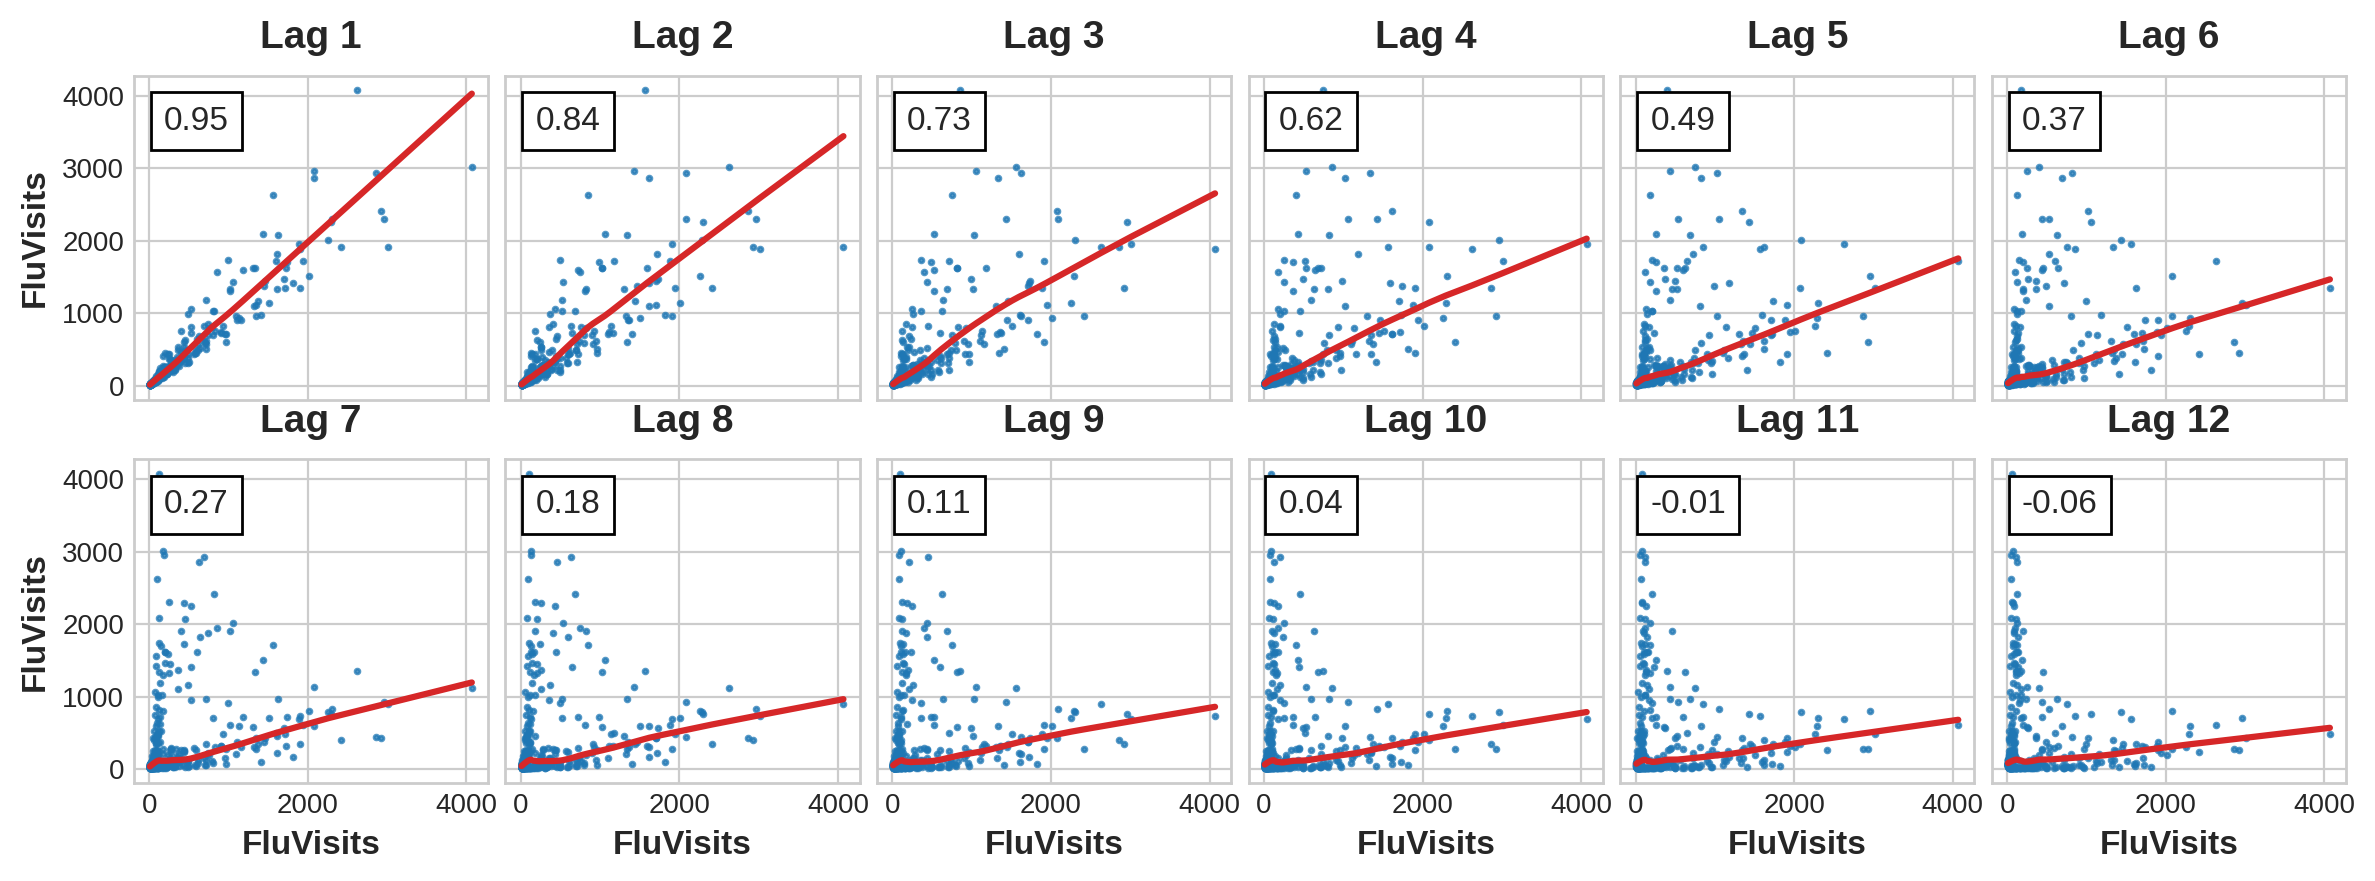

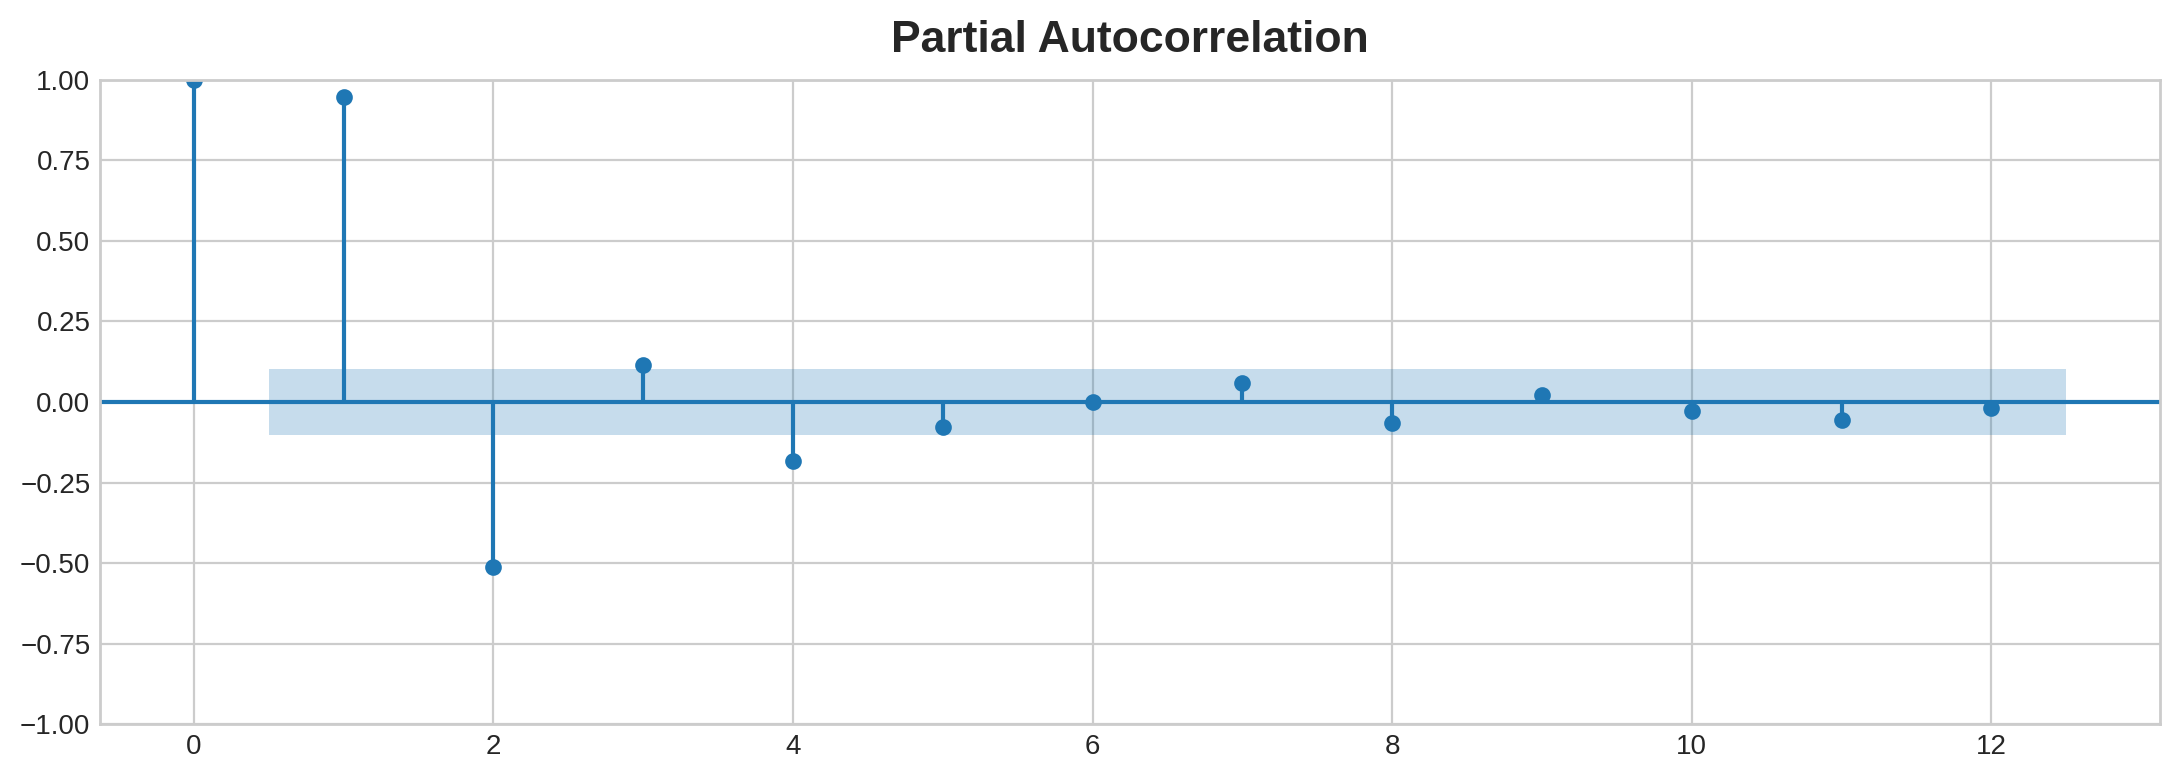

In [8]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

래그 플롯을 보면 `FluVisits`와 각 래그 사이의 관계가 대부분 선형임을 알 수 있고, 편자기상관은 래그 1, 2, 3, 4만으로 의존성을 포착할 수 있다고 알려 줍니다. Pandas에서는 `shift` 메서드로 손쉽게 래그를 만들 수 있습니다. 여기서는 래그로 인해 생기는 결측값을 `0.0`으로 채우겠습니다.


In [9]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

이전 강의에서는 학습 데이터 이후 원하는 만큼 예측을 만들 수 있었습니다. 하지만 래그 피처를 사용할 때는 필요한 래그 값이 존재하는 시점까지만 예측할 수 있습니다. 예를 들어 월요일에 래그 1 피처를 사용한다면, 화요일 값(아직 관측되지 않음)이 필요하므로 수요일 예측을 즉시 만들 수 없습니다.

6강에서 이런 문제를 다루는 전략을 살펴볼 것입니다. 이번 예제에서는 단순히 테스트 세트의 값을 사용하겠습니다.


In [10]:
# 타깃 시리즈와 학습/테스트 분할 생성
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# 학습 및 예측
model = LinearRegression()  # DeterministicProcess를 쓰지 않았으므로 `fit_intercept=True`
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)


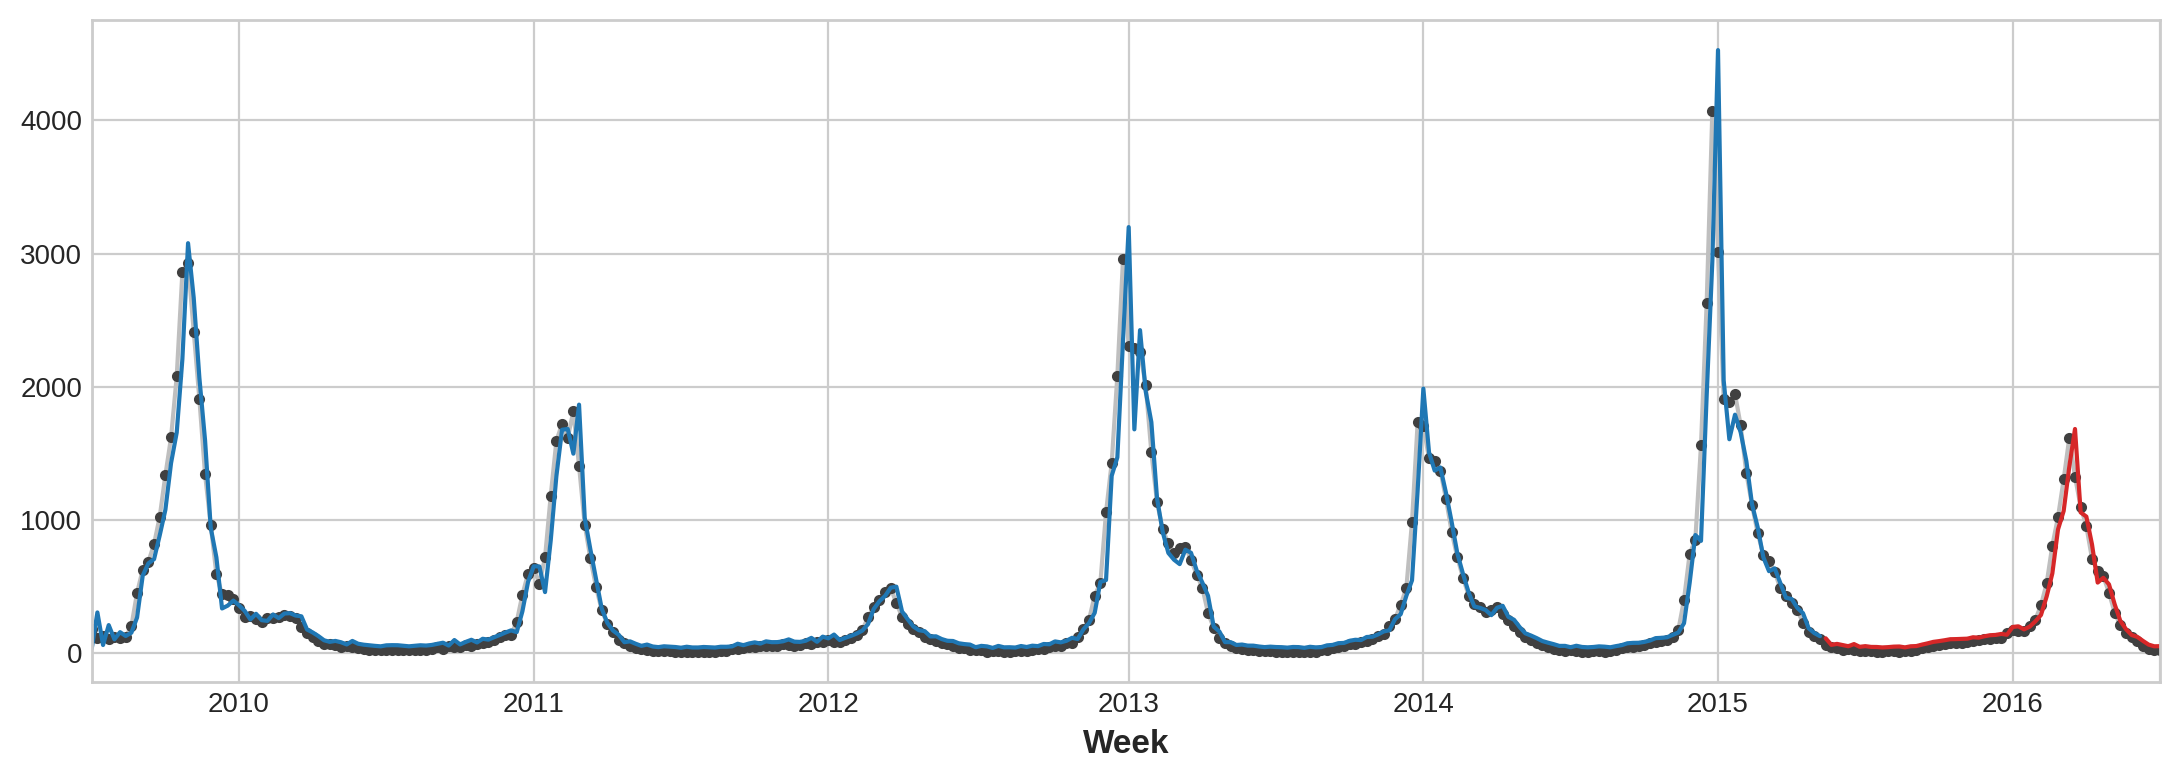

In [11]:

ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

---

예측 곡선만 살펴봐도 모델이 갑작스러운 변화에 반응하려면 한 단계가 필요하다는 사실을 알 수 있습니다. 타깃 시리즈의 래그만 피처로 사용하는 모델에서 흔히 나타나는 제약입니다.


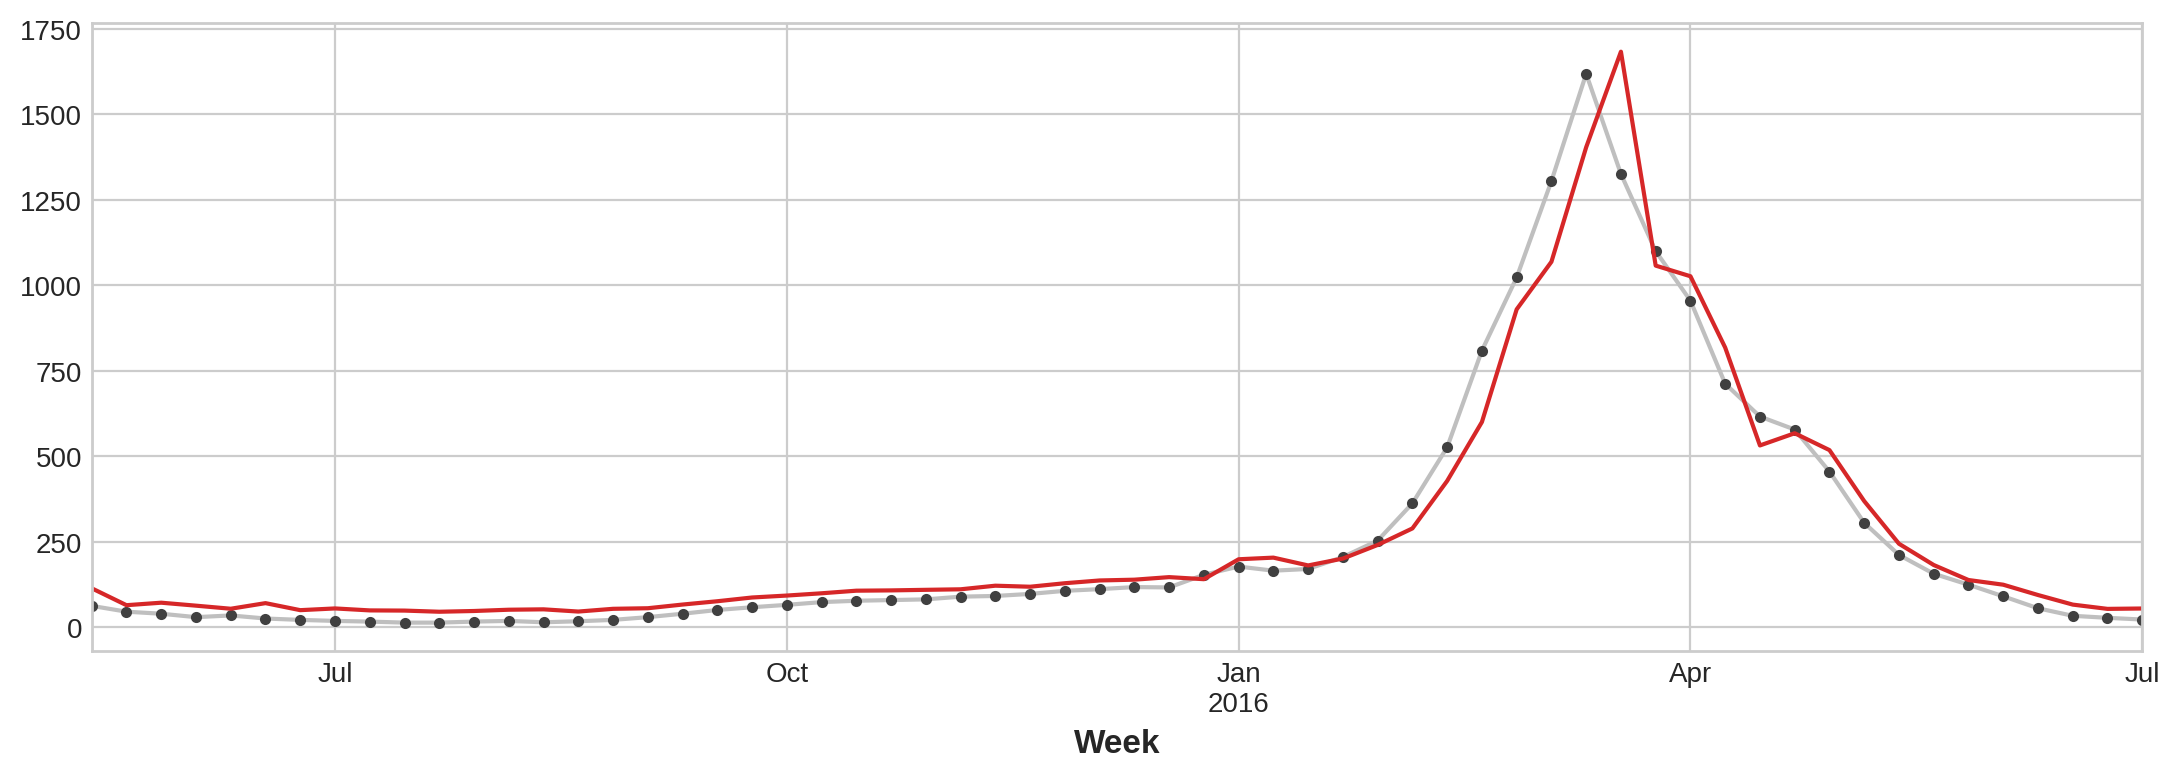

In [12]:

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

예측을 개선하려면 독감 발생 변화를 미리 알려 줄 **선행 지표(leading indicator)** 를 찾아볼 수 있습니다. 두 번째 접근법에서는 구글 트렌드에서 수집한 독감 관련 검색어의 인기 데이터를 학습 데이터에 추가하겠습니다.

`'FluCough'` 검색어와 타깃 `'FluVisits'`를 함께 그려 보면 이러한 검색어가 선행 지표로서 유용할 수 있음을 알 수 있습니다. 독감과 관련된 검색량은 병원 방문 수가 증가하기 몇 주 전에 먼저 상승하는 경향이 있기 때문입니다.


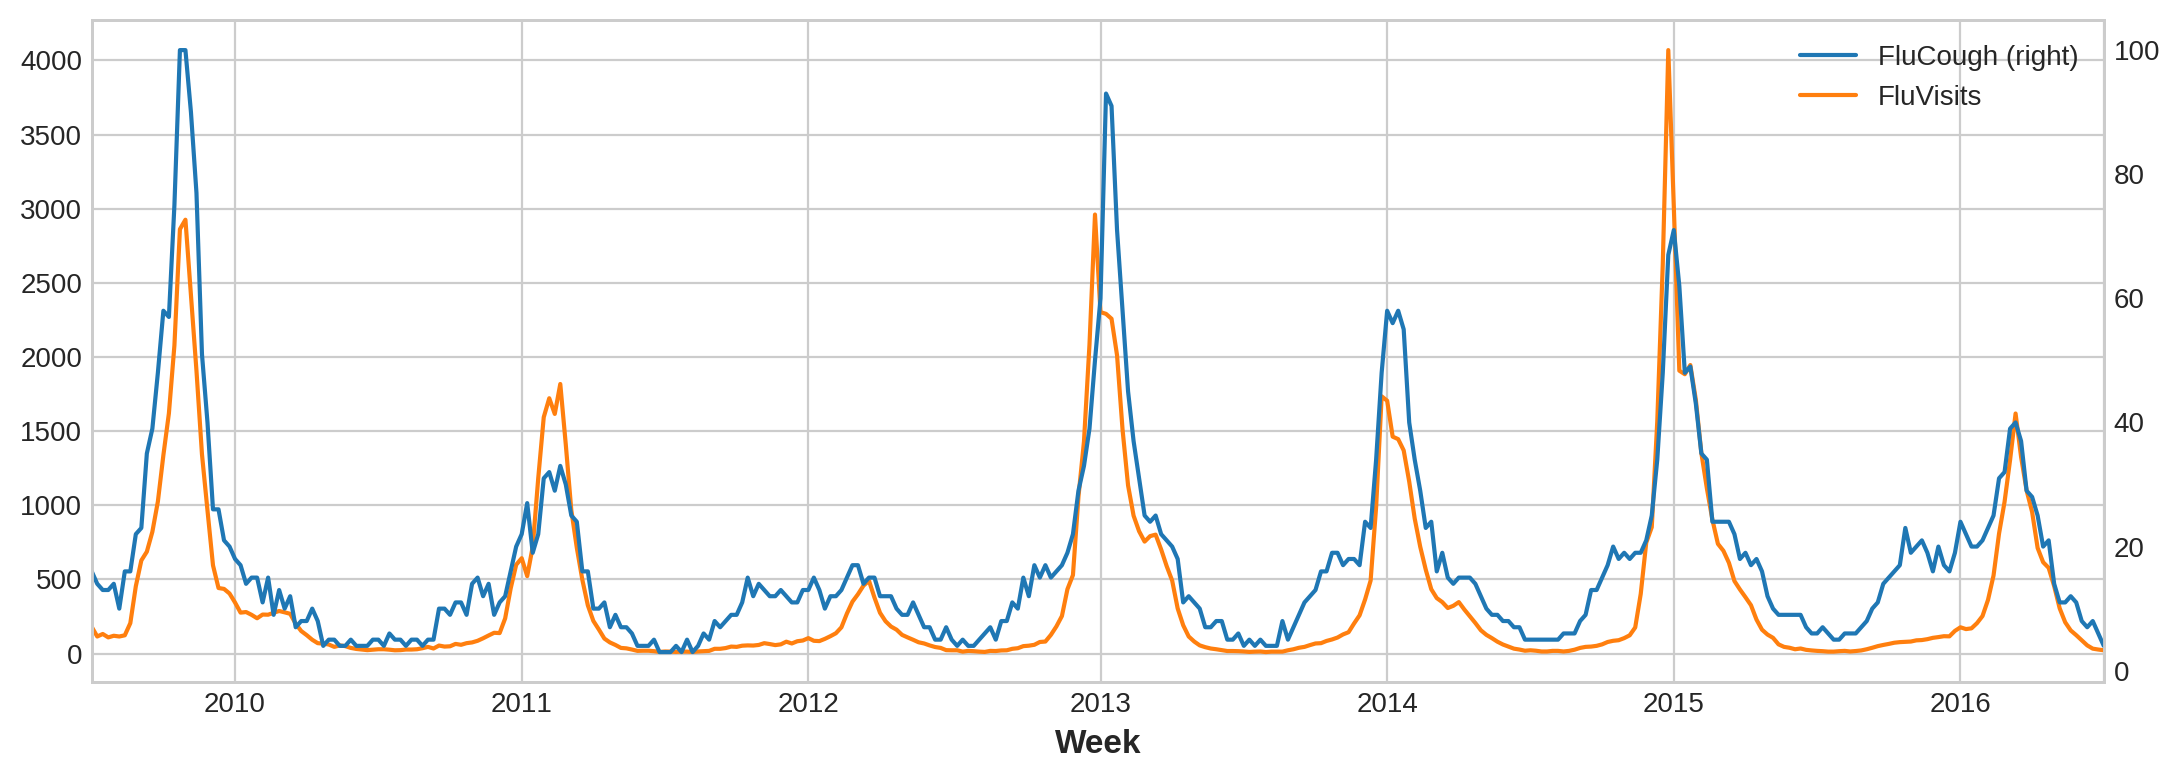

In [13]:

ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

데이터셋에는 총 129개의 검색어가 있지만 여기서는 일부만 사용하겠습니다.


In [14]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# 각 검색어에 대해 세 개의 래그 생성
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# 앞서와 같이 타깃에 대해 네 개의 래그 생성
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# 두 결과를 결합해 학습 데이터를 생성
X = pd.concat([X0, X1], axis=1).fillna(0.0)


예측이 다소 들쭉날쭉해 보이긴 하지만, 모델이 독감 방문 수의 급격한 증가를 이전보다 더 잘 예측하는 것처럼 보입니다. 이는 여러 검색어 시계열이 실제로 선행 지표로 도움이 되었음을 시사합니다.


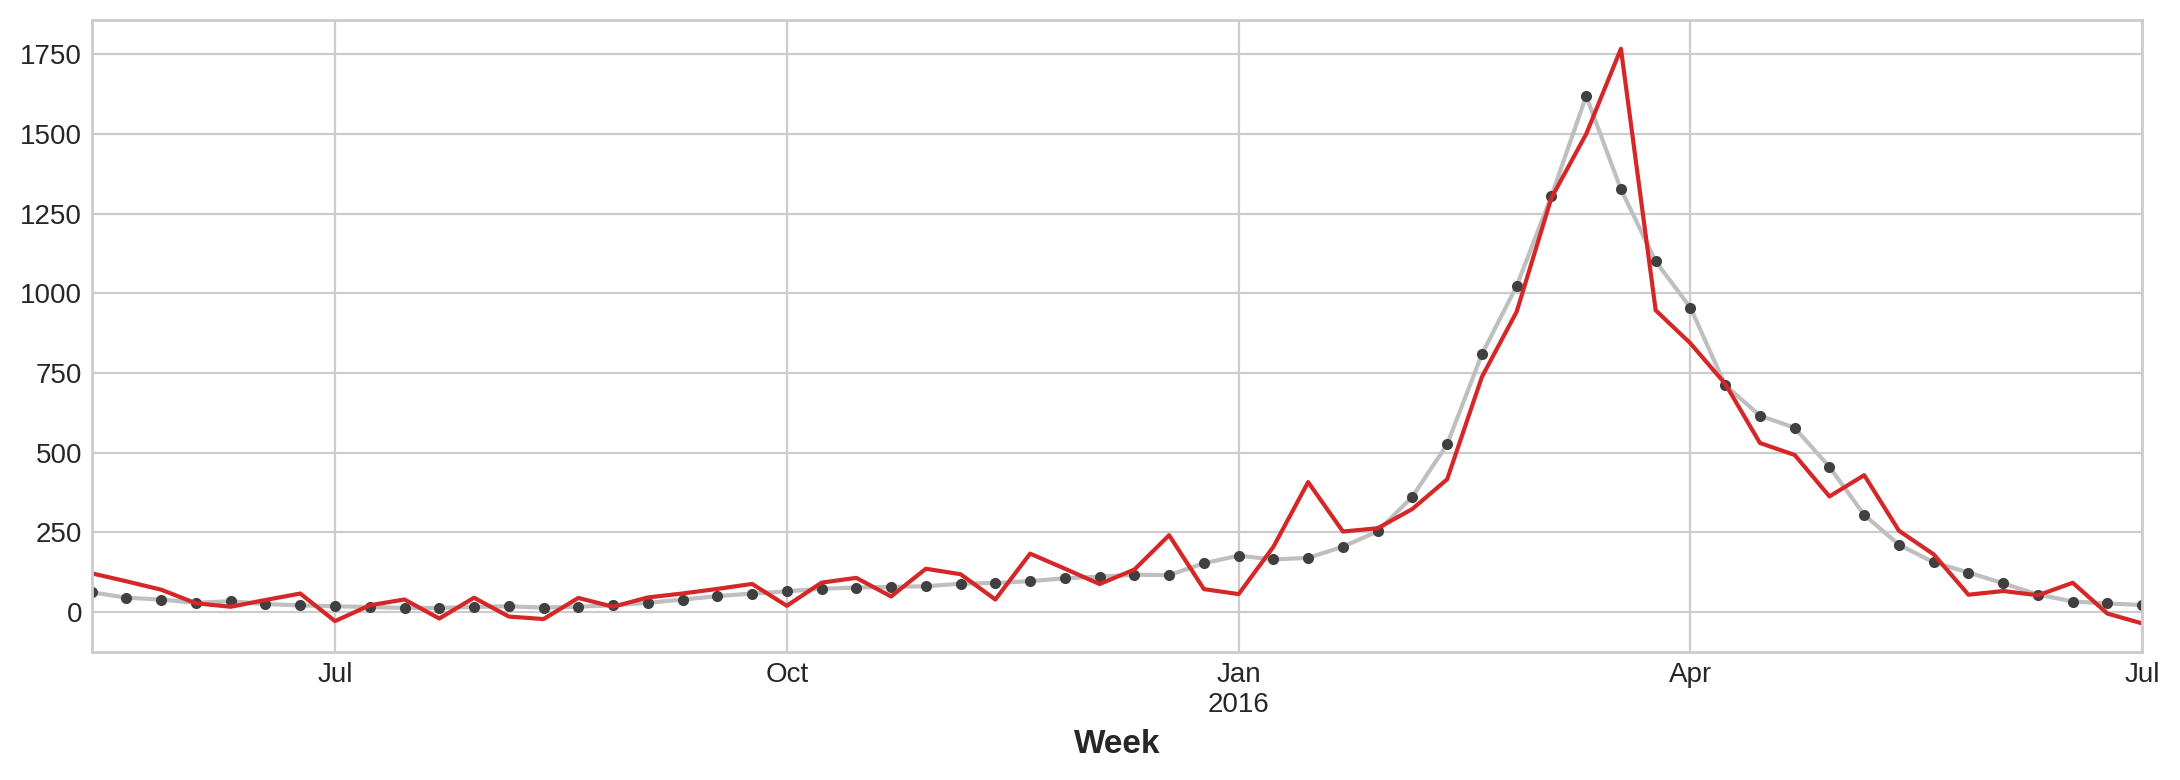

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

---

이번 강의에서 본 시계열은 뚜렷한 추세나 계절성이 없는, 소위 “순수한 주기형” 사례입니다. 하지만 현실에서는 추세, 계절성, 주기가 동시에 존재하는 경우가 흔합니다. 이런 시계열도 각 구성 요소에 맞는 피처를 추가해 선형 회귀로 모델링할 수 있습니다. 또는 각 구성 요소를 따로 학습한 뒤 결합할 수도 있는데, 다음 강의에서 *하이브리드 포캐스터(hybrid forecaster)* 를 통해 그 방법을 배울 것입니다.


# 소개 #

환경을 모두 준비하려면 이 셀을 실행하세요!


In [16]:
# 피드백 시스템 설정
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex4 import *

# 노트북 환경 설정
from pathlib import Path
from learntools.time_series.style import *  # 플롯 스타일 설정
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


comp_dir = Path('../input/store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)


----------------------------------------------------------------------------

모든 제품군이 주기적인 판매 패턴을 보이는 것은 아니며, 평균 매출 시리즈도 마찬가지입니다. 하지만 학용품과 사무용품은 추세나 계절성만으로는 설명하기 어려운 성장과 감소 패턴을 보입니다. 이번 문제와 다음 문제에서는 학용품·사무용품 매출의 주기를 래그 피처로 모델링해 보겠습니다.

추세와 계절성도 상관도와 래그 플롯에 직렬 의존성을 만들어 냅니다. 순수한 *주기* 만을 확인하려면 시리즈에서 계절성을 먼저 제거하겠습니다. 다음 셀의 코드를 사용해 *Supply Sales* 시리즈의 계절을 제거하고, 결과를 `y_deseason` 변수에 저장하세요.


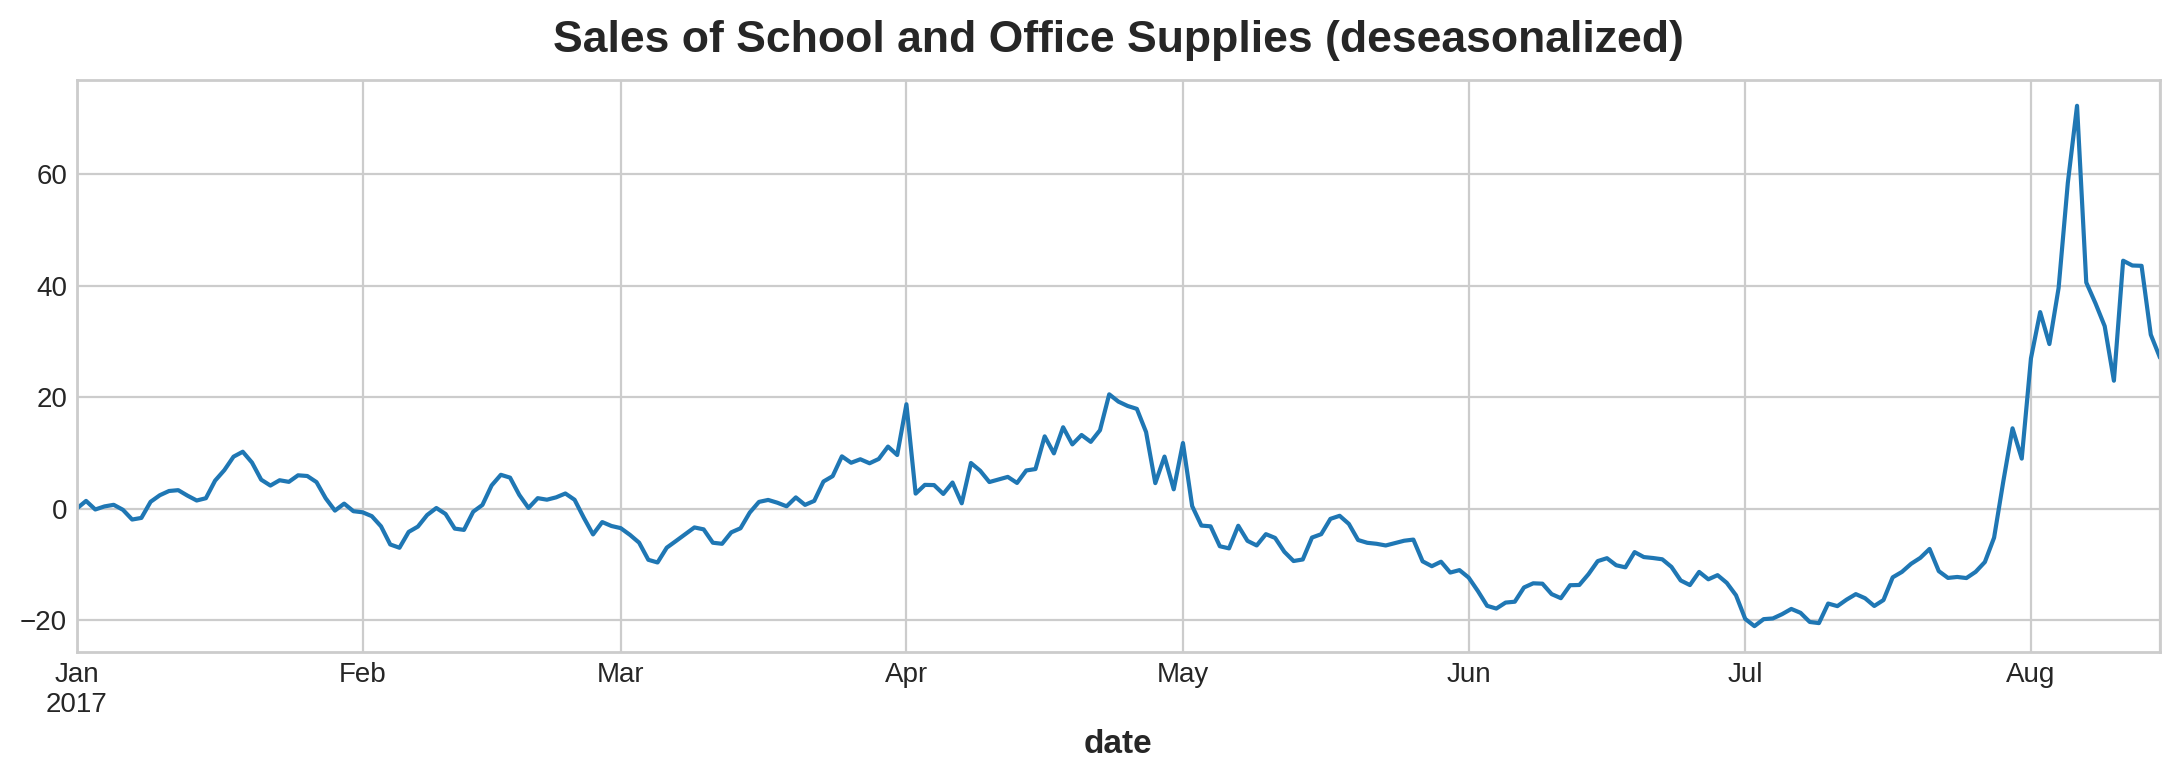

In [17]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

이렇게 계절을 제거한 시리즈에도 주기 패턴이 보이나요? 직관을 확인하기 위해 추세를 다룰 때처럼 이동 평균 플롯으로 주기만 남겨 볼 수 있습니다. 창을 너무 짧게 잡으면 단기 계절성이 남아 있고, 너무 길면 주기까지 사라지므로 적절한 길이를 골라야 합니다.

# 1) 주기 플롯 만들기

`y`(학용품·사무용품 매출 시리즈)에서 7일 이동 평균을 만드세요. 창은 중앙에 놓되 `min_periods` 인수는 사용하지 마세요.


Text(0.5, 1.0, 'Seven-Day Moving Average')

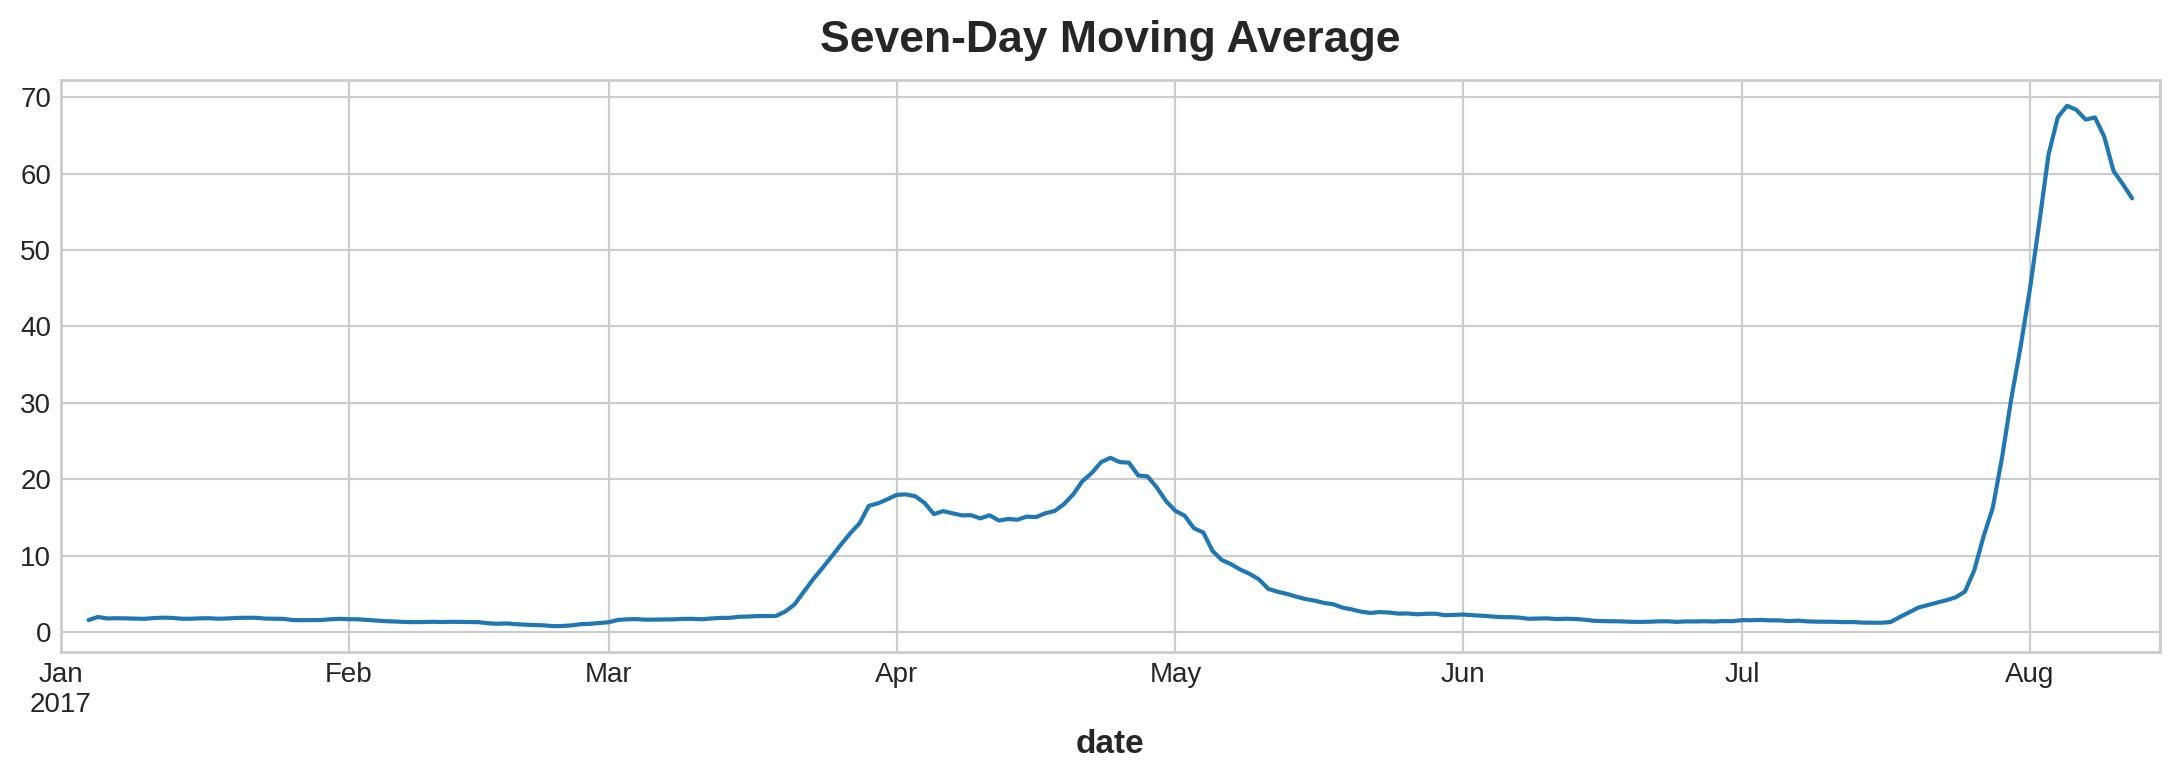

In [19]:
# 여기에 코드를 작성하세요
y_ma = y.rolling(window=7, center=True).mean()


# 플롯
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average")


In [20]:
# 아래 줄은 힌트나 해설 코드를 보여 줍니다
#q_1.hint()
#q_1.solution()


이동 평균 플롯이 계절을 제거한 시리즈와 닮아 있는 것이 보이나요? 두 그래프 모두 주기적 행동을 보여 줍니다.

-------------------------------------------------------------------------------

이제 계절을 제거한 시리즈에서 직렬 의존성을 살펴보겠습니다. 편자기상관 상관도와 래그 플롯을 확인해 보세요.


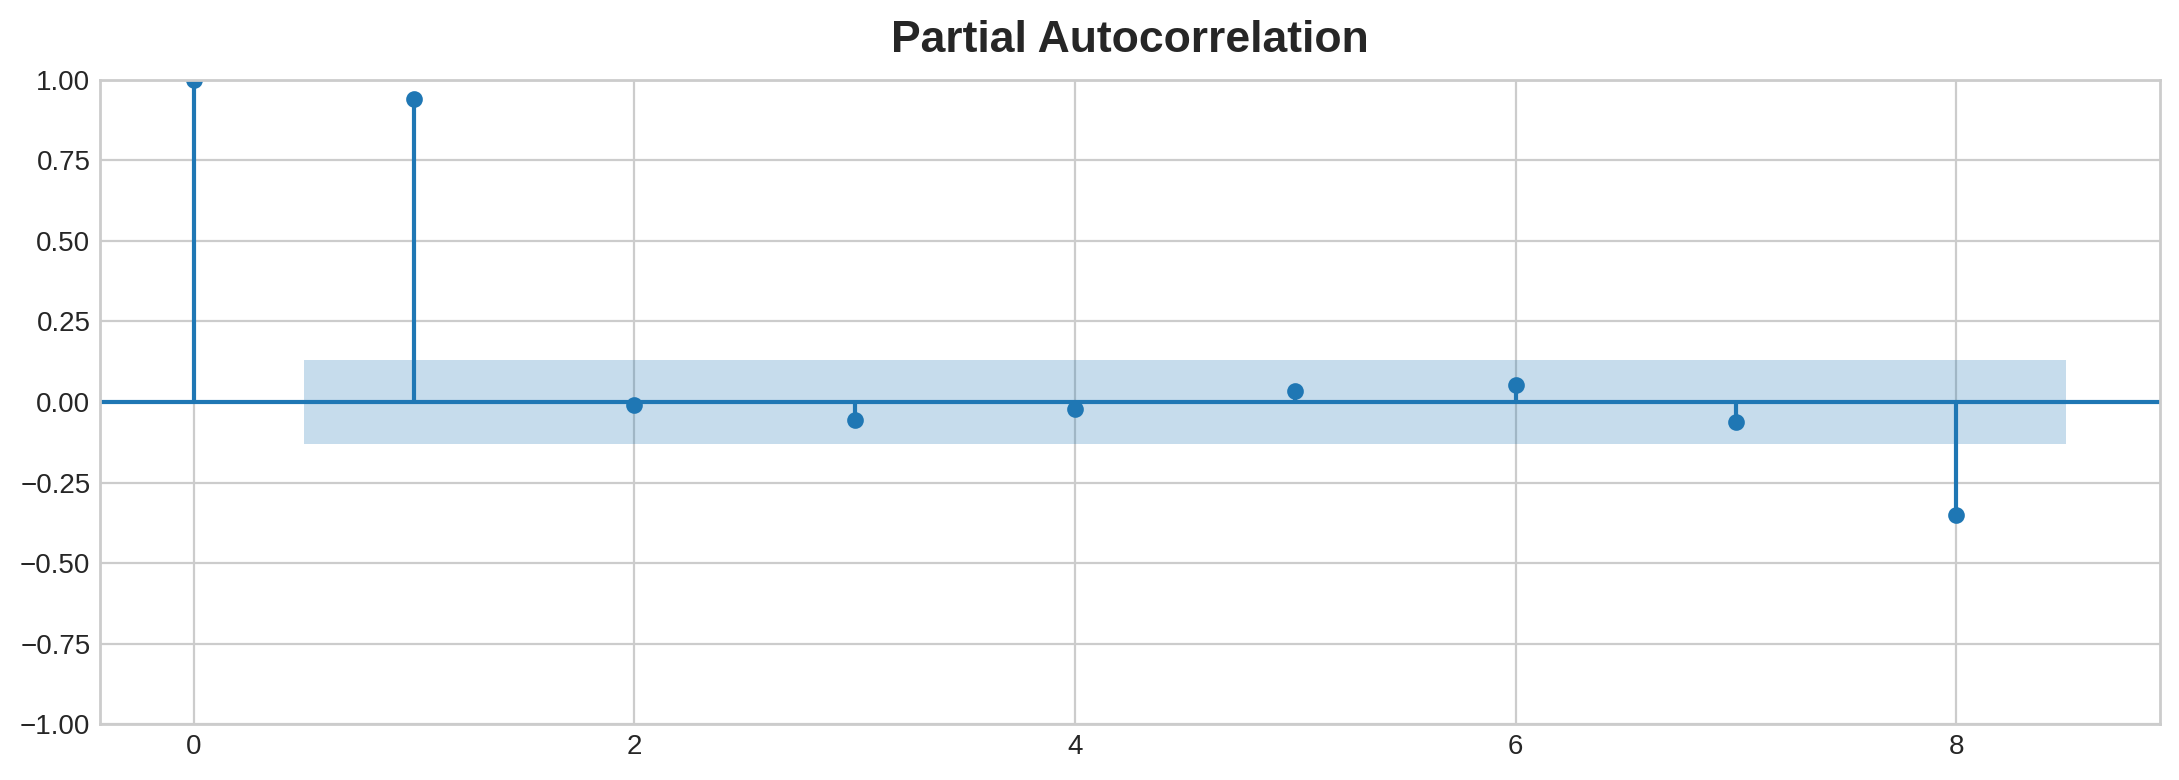

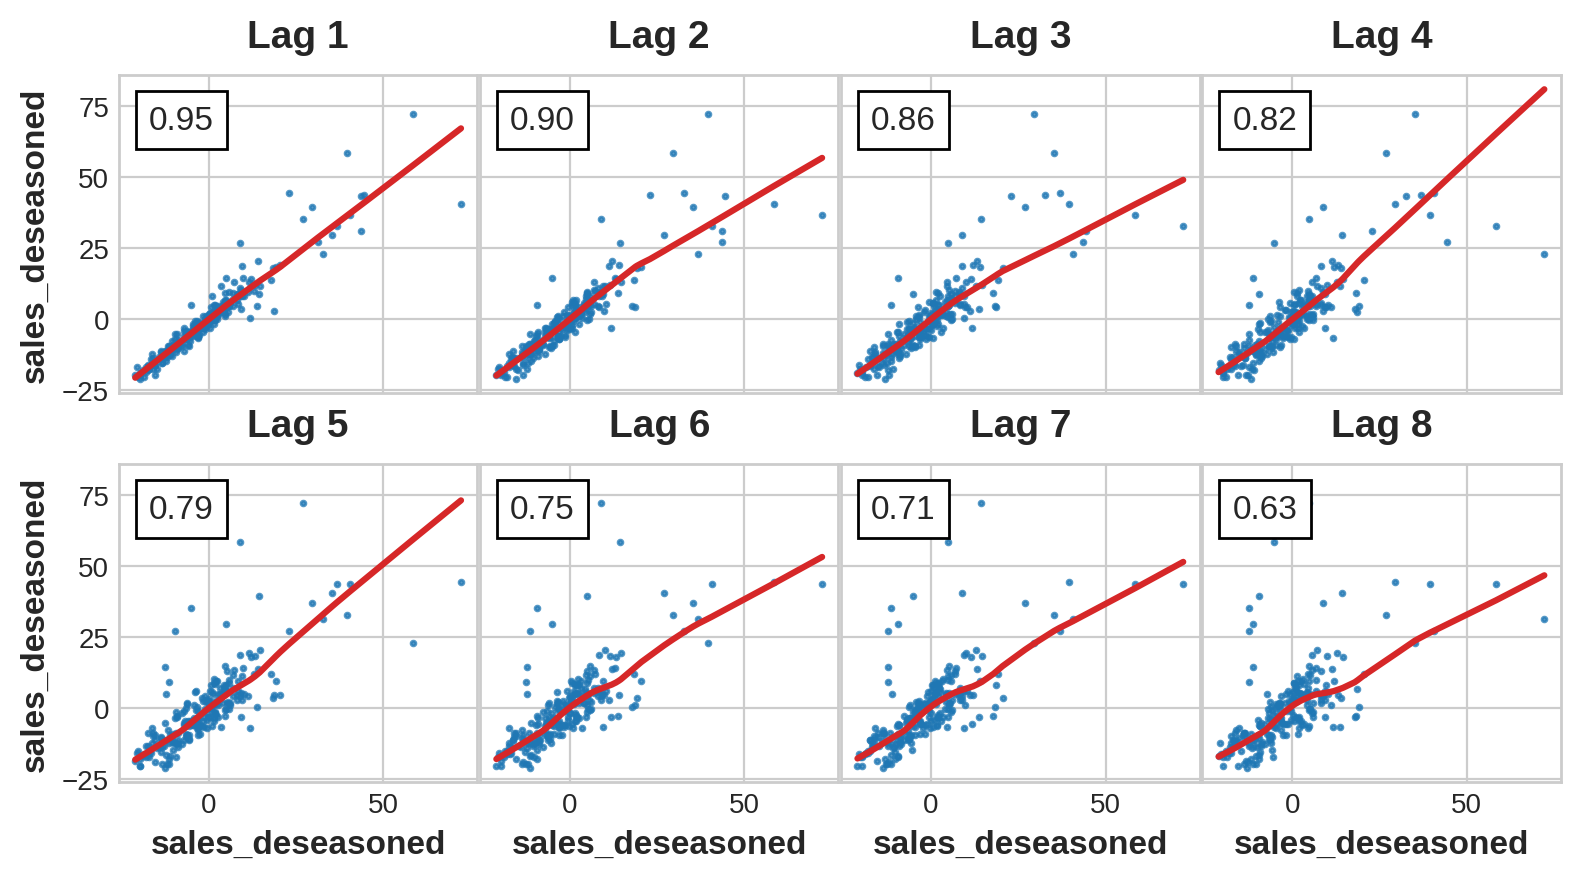

In [21]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

# 2) *Store Sales*의 직렬 의존성 살펴보기

상관도에 따르면 어떤 래그가 유의미해 보이나요? 래그 플롯이 상관도에서는 보이지 않았던 관계를 보여 주나요?

답을 생각해 본 뒤 다음 셀을 실행하세요.


In [22]:
# 해설 보기
q_2.check()


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. The lag plot suggests the effect is mostly linear.


-------------------------------------------------------------------------------

튜토리얼에서 *선행 지표(leading indicator)* 는 미래의 타깃 값을 미리 알려 줄 수 있는 시계열이라고 했습니다. 선행 지표는 타깃보다 앞서 변하므로 “사전 경고” 역할을 합니다.

대회 데이터셋에는 선행 지표로 유용할 수 있는 `onpromotion` 시리즈가 있습니다. 이는 해당 날짜에 특별 프로모션 중인 상품 수를 나타냅니다. 프로모션 여부는 회사가 미리 결정하므로 “미래를 엿보는” 문제는 없습니다. 예를 들어 화요일의 `onpromotion` 값으로 월요일 매출을 예측해도 괜찮습니다.

다음 셀을 사용해 `onpromotion`의 선행·지연 값을 학용품·사무용품 매출과 함께 그려 보세요.


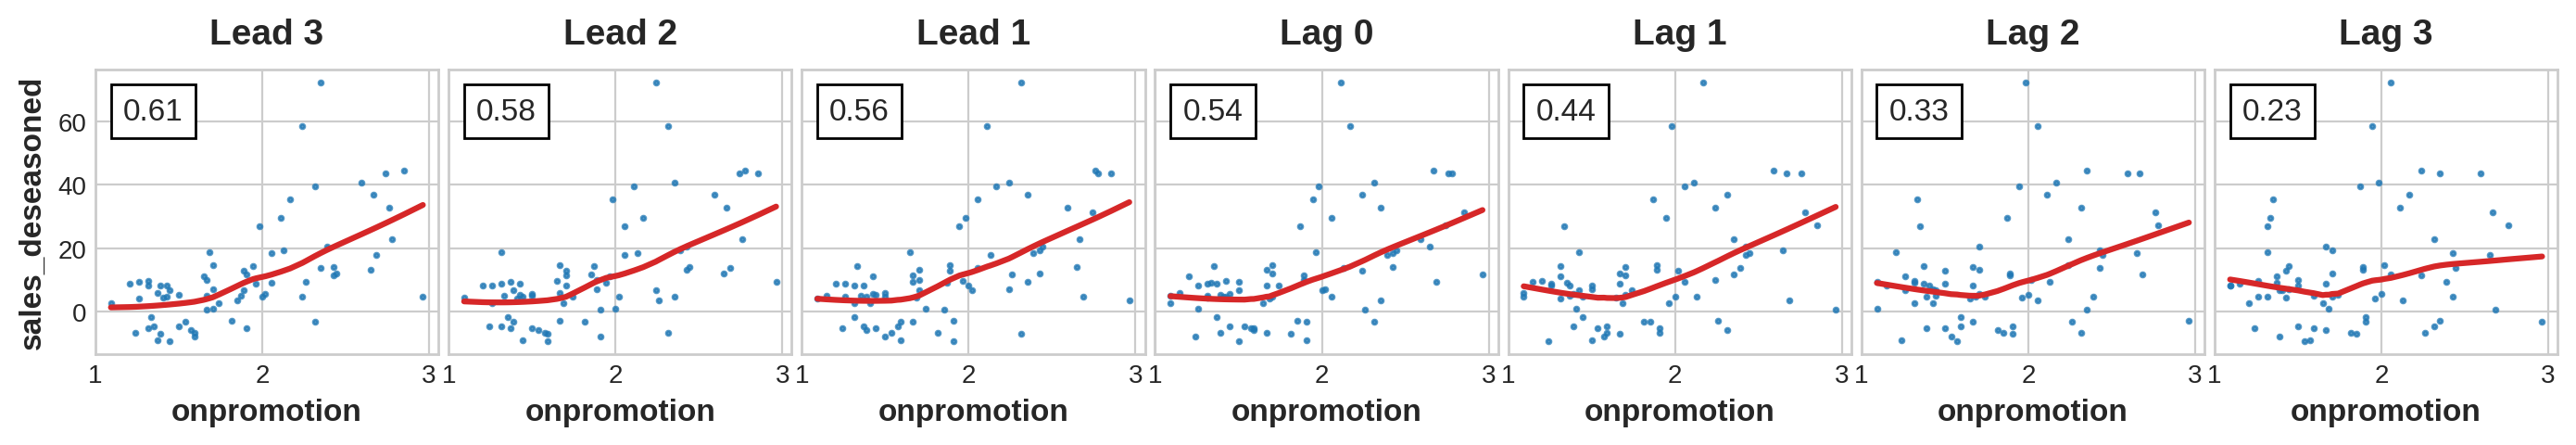

In [23]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# 프로모션이 없었던 날은 제외
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);


# 3) 시계열 피처 살펴보기

`onpromotion`의 선행 값이나 지연 값 중 모델에 도움이 될 만한 피처가 보이나요?


In [24]:
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The lag plot indicates that both leading and lagged values of `onpromotion` are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.


-------------------------------------------------------------------------------

# 4) 시계열 피처 만들기

문제 3의 해설에서 제안한 피처를 만드세요. 해당 시리즈에서 사용할 만한 피처가 없다면 빈 데이터프레임 `pd.DataFrame()`을 답으로 사용하세요.


In [26]:
# 여기에 코드를 작성하세요: `y_deseason`에서 피처 만들기
X_lags = pd.concat(
    [y_deseason.shift(k).rename(f"y_lag_{k}") for k in [1, 7, 14]],
    axis=1
)

# 여기에 코드를 작성하세요: `onpromotion`에서 피처 만들기
# 필요하다면 `pd.concat`을 사용하세요
X_promo = pd.concat(
    [
        onpromotion.shift(1).rename("promo_lag_1"),
        onpromotion.shift(7).rename("promo_lag_7"),
        onpromotion.shift(-1).rename("promo_lead_1")
    ],
    axis=1
)

X = pd.concat([X_lags, X_promo], axis=1)
y, X = y.align(X, join='inner')




In [27]:
# 아래 줄은 힌트나 해설 코드를 제공합니다
#q_4.hint()
#q_4.solution()


In [30]:
X = pd.concat([X_lags, X_promo], axis=1)
y, X = y.align(X, join='inner')

# NaN 제거
X = X.dropna()
y = y.loc[X.index]


다음 셀의 코드를 사용하면 결과 모델의 예측을 확인할 수 있습니다.


Training RMSLE: 0.61753
Validation RMSLE: 0.73654


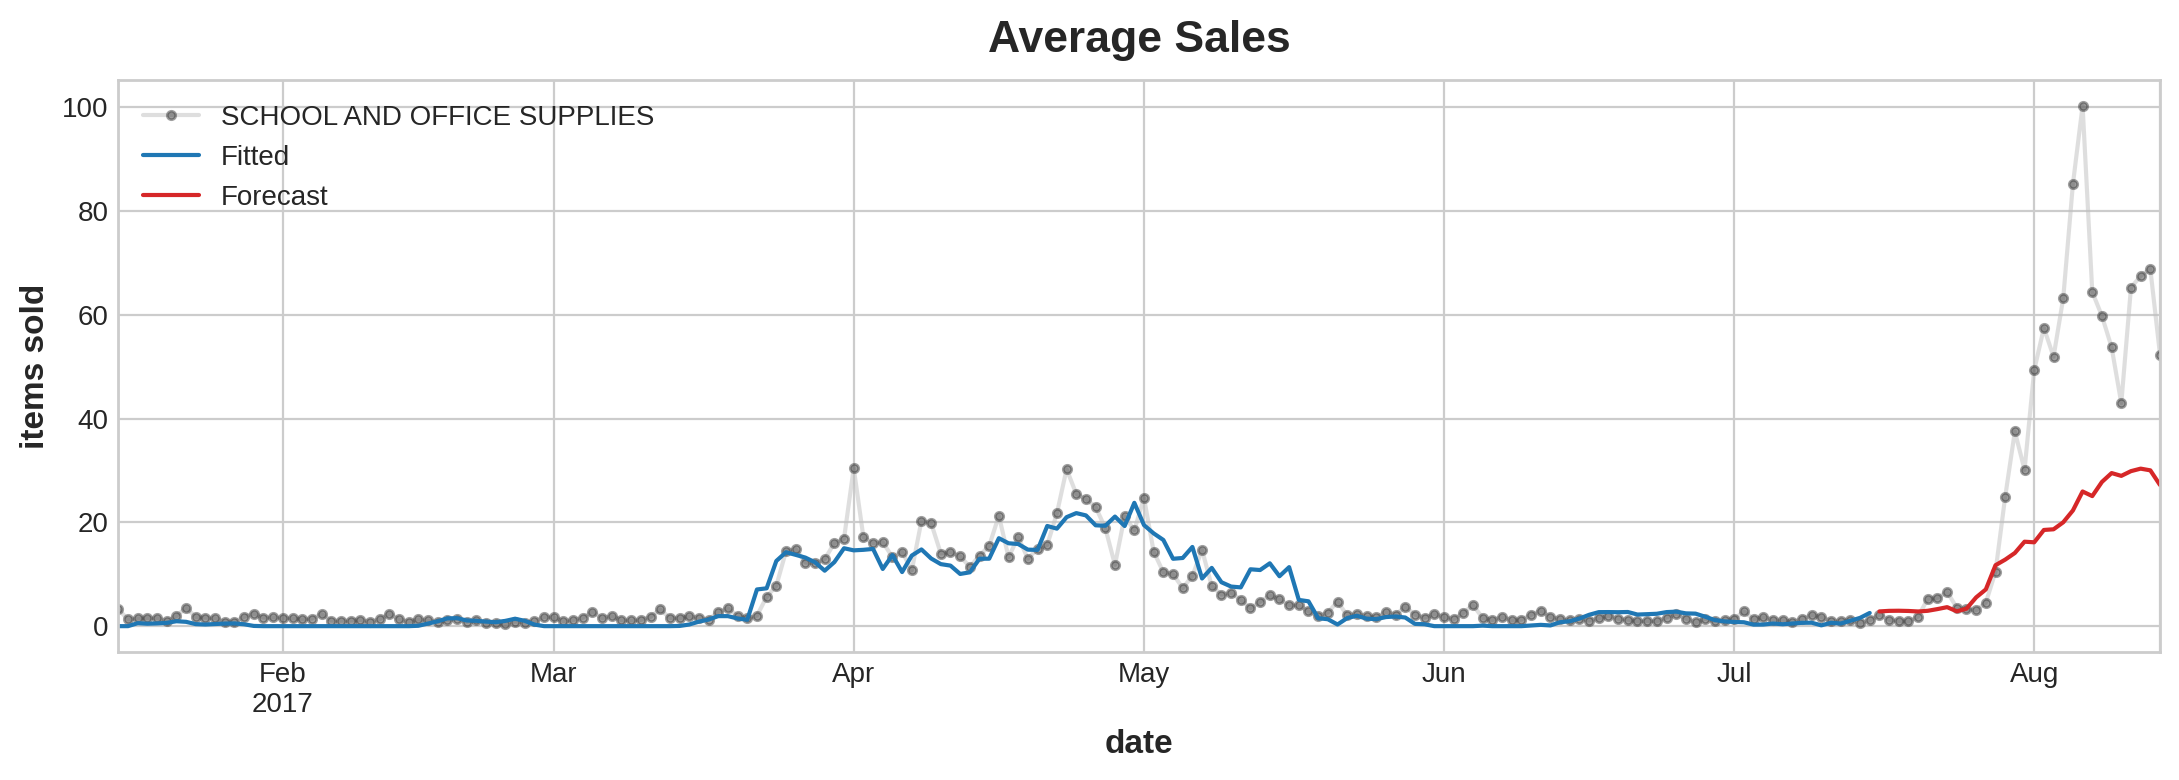

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

-------------------------------------------------------------------------------

Kaggle 예측 대회 우승자들은 종종 이동 평균과 같은 롤링 통계 피처를 추가하곤 했습니다. 특히 XGBoost 같은 GBDT 알고리즘과 함께 사용할 때 효과가 좋았습니다.

2강에서 이동 평균으로 추세를 추정하는 방법을 배웠습니다. 롤링 통계를 피처로 만들 때도 비슷하지만, “미래 정보”가 섞이지 않도록 신경 써야 합니다. 우선 결과를 창의 오른쪽 끝에 맞춰야 하므로 `rolling` 메서드에서 `center=False`(기본값)를 사용해야 합니다. 그리고 타깃은 한 스텝 래그하여 계산해야 합니다.


# 5) 통계적 피처 만들기

다음 셀의 코드를 수정하여 아래 피처를 만드세요.
- 래그된 타깃의 14일 이동 중앙값(`median`)
- 래그된 타깃의 7일 이동 표준편차(`std`)
- 중심 창을 사용하는 7일 프로모션 수 합계(`sum`)


In [32]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

# 래그된 타깃의 28일 평균
mean_7 = y_lag.rolling(7).mean()
# 여기에 코드를 작성하세요: 래그된 타깃의 14일 중앙값
median_14 = ____
# 여기에 코드를 작성하세요: 래그된 타깃의 7일 표준편차
std_7 = ____
# 여기에 코드를 작성하세요: 중심 창을 사용하는 7일 프로모션 합계
promo_7 = ____



In [33]:
# 아래 줄은 힌트나 해설 코드를 보여 줍니다
#q_5.hint()
#q_5.solution()


Pandas의 [`Window` 문서](https://pandas.pydata.org/pandas-docs/stable/reference/window.html)에서 계산할 수 있는 다른 통계를 확인해 보세요. `rolling` 대신 `ewm`을 사용하면 “지수 가중” 창을 만들 수 있는데, 시간이 지날수록 효과가 서서히 감소하는 모습을 더 현실적으로 표현할 수 있습니다.
